In [1]:
print("Hello")

Hello


# Simulating a simple blockchain network

In [2]:

import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from igraph import Graph


# Define the Simulation Environment
env = simpy.Environment()


# Create Blockchain node class:
class Node:
    def __init__(self, env, node_id, state_data):
        self.env = env
        self.node_id = node_id
        self.chain = []
        self.state_data = state_data
        self.action = env.process(self.run())

    def run(self):
        while True:
            yield self.env.timeout(np.random.exponential(10))
            block = f"Block_{len(self.chain)+1}_Node_{self.node_id}"
            self.chain.append(block)
            # Record state
            self.state_data.append({
                'time': self.env.now,
                'node_id': self.node_id,
                'chain_length': len(self.chain)
            })
            print(f"Time {self.env.now}: Node {self.node_id} mined {block}")


state_data = []
num_nodes = 5
nodes = [Node(env, i, state_data) for i in range(num_nodes)]

simulation_time = 100
env.run(until=simulation_time)
state_df = pd.DataFrame(state_data)



Time 1.6603778379066447: Node 3 mined Block_1_Node_3
Time 2.372537920918883: Node 0 mined Block_1_Node_0
Time 6.6669790261715365: Node 4 mined Block_1_Node_4
Time 9.431484556245671: Node 3 mined Block_2_Node_3
Time 10.038402100408154: Node 2 mined Block_1_Node_2
Time 10.892262231410674: Node 4 mined Block_2_Node_4
Time 20.13072653945204: Node 4 mined Block_3_Node_4
Time 22.834903829384018: Node 0 mined Block_2_Node_0
Time 23.219820863773407: Node 4 mined Block_4_Node_4
Time 25.822207086408685: Node 3 mined Block_3_Node_3
Time 27.418048160672267: Node 3 mined Block_4_Node_3
Time 29.247529383630972: Node 3 mined Block_5_Node_3
Time 29.607576401306325: Node 2 mined Block_2_Node_2
Time 30.120143872942897: Node 4 mined Block_5_Node_4
Time 30.52883551486195: Node 3 mined Block_6_Node_3
Time 31.164805249220496: Node 3 mined Block_7_Node_3
Time 31.92158478293383: Node 4 mined Block_6_Node_4
Time 32.51849012488405: Node 1 mined Block_1_Node_1
Time 33.58592635410484: Node 4 mined Block_7_Node_4


# Analyzing Chain Lengh other time

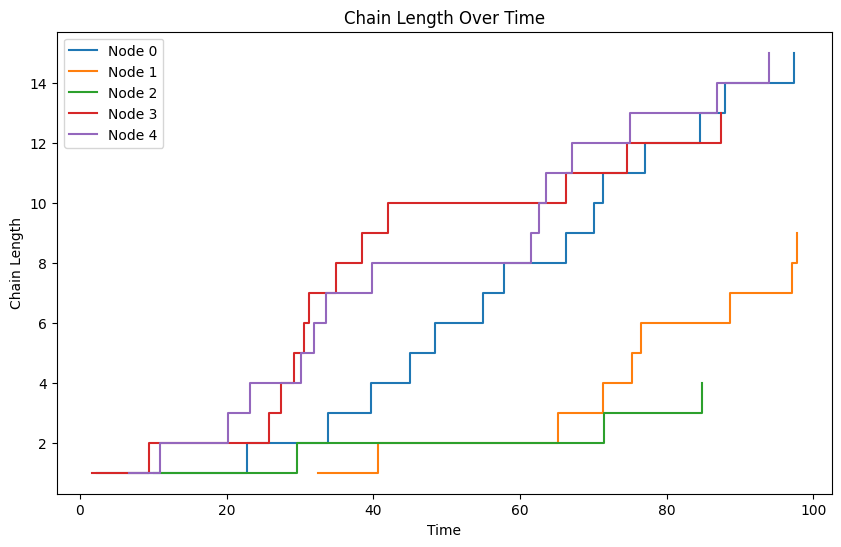

In [3]:
plt.figure(figsize=(10,6))
for node_id in range(num_nodes):
    node_data = state_df[state_df['node_id'] == node_id]
    plt.step(node_data['time'], node_data['chain_length'], where='post', label=f'Node {node_id}')
plt.xlabel('Time')
plt.ylabel('Chain Length')
plt.title('Chain Length Over Time')
plt.legend()
plt.show()

In [4]:
# identifying discontinueties
state_df['chain_diff'] = state_df.groupby('node_id')['chain_length'].diff().fillna(0)
discontinuities = state_df[state_df['chain_diff'] > 1]

## Analying graph typologie using Ipgrph


In [5]:
# Assuming nodes communicate with each other, we can model the network topology.
g = Graph.Full(num_nodes)  # Fully connected network

In [6]:
# The minimum cut of a graph is the smallest number of edges that, if removed, would disconnect the graph.
min_cut_value = g.mincut().value
print(f"The minimum cut of the network graph is {min_cut_value}")

The minimum cut of the network graph is 4.0


Explanation:

	•	In a fully connected network, the mincut is num_nodes - 1.
	•	We can simulate networks with different topologies and analyze their mincuts.

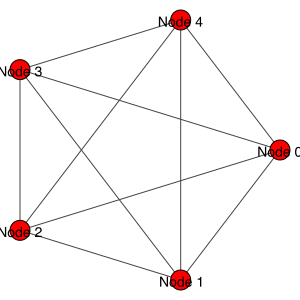

In [7]:
layout = g.layout("circle")
igraph.plot(g, layout=layout, vertex_label=[f"Node {i}" for i in range(num_nodes)], bbox=(300,300))

# Applying multi level MonteCarlo Simulation

In [8]:
def mlmc_simulation(levels, samples_per_level):
    estimates = []
    for level in range(levels):
        samples = samples_per_level * (2 ** level)
        results = []
        for _ in range(samples):
            # Simulate and collect some metric, e.g., average chain length
            chain_lengths = [len(node.chain) for node in nodes]
            avg_chain_length = np.mean(chain_lengths)
            results.append(avg_chain_length)
        estimate = np.mean(results)
        estimates.append(estimate)
        print(f"Level {level}, Samples {samples}, Estimate {estimate}")
    return estimates

In [9]:
levels = 3
samples_per_level = 10
mlmc_estimates = mlmc_simulation(levels, samples_per_level)

Level 0, Samples 10, Estimate 11.2
Level 1, Samples 20, Estimate 11.199999999999998
Level 2, Samples 40, Estimate 11.2


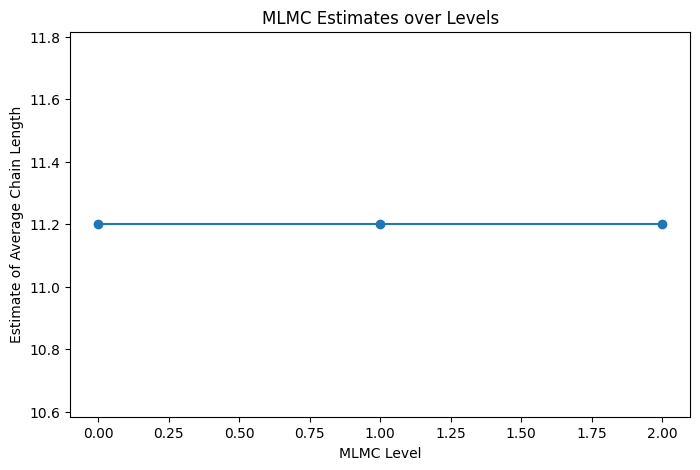

In [10]:
plt.figure(figsize=(8,5))
plt.plot(range(levels), mlmc_estimates, marker='o')
plt.xlabel('MLMC Level')
plt.ylabel('Estimate of Average Chain Length')
plt.title('MLMC Estimates over Levels')
plt.show()

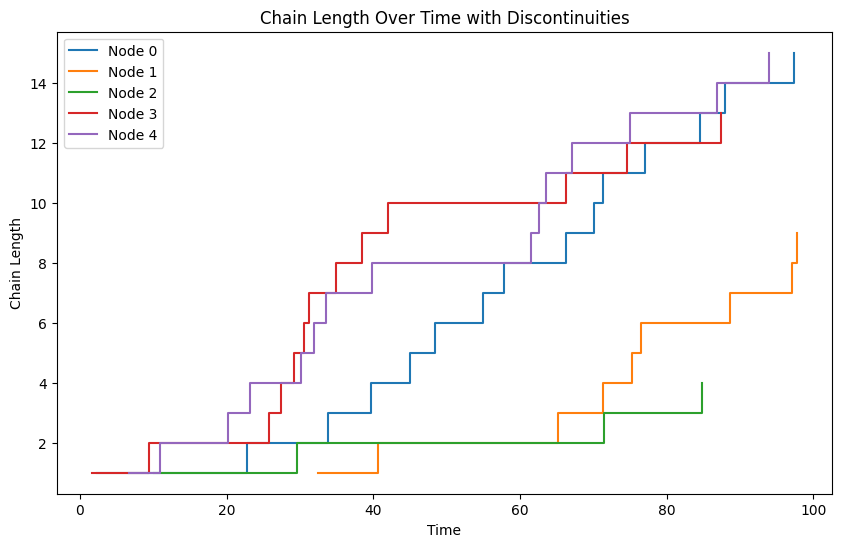

In [11]:
plt.figure(figsize=(10,6))
for node_id in range(num_nodes):
    node_data = state_df[state_df['node_id'] == node_id]
    plt.step(node_data['time'], node_data['chain_length'], where='post', label=f'Node {node_id}')
    discontinuity_times = discontinuities[discontinuities['node_id'] == node_id]['time']
    for dt in discontinuity_times:
        plt.axvline(x=dt, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Chain Length')
plt.title('Chain Length Over Time with Discontinuities')
plt.legend()
plt.show()